# RL - Frozen lake

In [95]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import random

%matplotlib inline


In [63]:
def softmax(x, temperature=1.0):
    x = np.array(x)
    if temperature <= 0:
        raise ValueError
    z = x / temperature
    z -= np.max(z)  
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z)

In [64]:
def choose_action(Q, state, n_actions, epsilon=0.1, policy="epsilon_greedy", temperature=1.0):
    # use epilson to expore or exploit
    if policy == "epsilon_greedy":
        if np.random.rand() < epsilon:
            return np.random.randint(n_actions)
        else:
            return np.argmax(Q[state])
    
    elif policy == "boltzmann":
        # q values into probability
        probs = softmax(Q[state], temperature)
        return np.random.choice(np.arange(n_actions), p=probs)
    else:
        raise ValueError("Unknown policy type")

In [65]:
# setting up initial parameters that control training
def train_q_learning(
    is_slippery=True,
    alpha=0.8,          
    gamma=0.95,        
    epsilon=0.1,       
    episodes=2000,      
    epsilon_decay=0.995,
    min_epsilon=0.01,
    step_penalty=0.0,  
    hole_penalty=0.0,   
    policy="epsilon_greedy",  
    temperature=1.0,    
    seed=42
):

    # create the frozen lake env and set to slippery
    env = gym.make("FrozenLake-v1", is_slippery=is_slippery)
    env.reset(seed=seed)
    np.random.seed(seed)
    random.seed(seed)

    # number of states and actions
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))  

    rewards = []  
    success = []  

    # set each iteration for an episode
    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        # choose  between epsilon or boltzmann
        while not done:
            action = choose_action(Q, state, n_actions, epsilon, policy, temperature)

            next_state, reward, terminated, truncated, _ = env.step(action)

            # penalty for steps
            reward += step_penalty
            if terminated and reward == step_penalty + 0.0:  # fell in hole
                reward += hole_penalty

            # best future reward
            best_next = np.max(Q[next_state])
            Q[state, action] += alpha * (reward + gamma * best_next - Q[state, action])

            # track reward and move forward
            total_reward += reward
            state = next_state
            done = terminated or truncated

        # store reward and if goal achieved
        rewards.append(total_reward)
        success.append(1 if total_reward > 0 else 0)

        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        if (episode + 1) % 500 == 0:
            avg_reward = np.mean(rewards[-500:])
            print(f"Episode {episode+1}/{episodes} | Avg reward last 500: {avg_reward:.3f} | ε={epsilon:.3f}")

    env.close()
    return Q, rewards, success


In [66]:
def plot_learning_curves(rewards, success, title="", window=100, fig_num="Fig 1"):
    def moving_average(data, w):
        return np.convolve(data, np.ones(w)/w, mode="valid")

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # average reward
    axs[0].plot(moving_average(rewards, window))
    axs[0].set_title("Average Reward per Episode")
    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("Reward")
    # Add figure label at bottom
    axs[0].text(0.5, -0.2, f"{fig_num}a", transform=axs[0].transAxes, ha="center", fontsize=12)

    # success rate
    axs[1].plot(moving_average(success, window))
    axs[1].set_title("Success Rate (Goal Reached)")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Success Rate")
    # Add figure label at bottom
    axs[1].text(0.5, -0.2, f"{fig_num}b", transform=axs[1].transAxes, ha="center", fontsize=12)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# heat map of qtable
def plot_q_heatmap(Q, title="Q-table Heatmap", fig_num="Fig 2"):
    plt.figure(figsize=(8, 5))
    sns.heatmap(Q, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(title)
    plt.xlabel("Action (0=Left,1=Down,2=Right,3=Up)")
    plt.ylabel("State")
    
    plt.gcf().text(0.5, -0.05, fig_num, ha="center", fontsize=12)
    plt.show()


Here it can be observed that the agent is learning as expected and the decay decreases per episode. 

Episode 500/2000 | Avg reward last 500: 0.737 | ε=0.016
Episode 1000/2000 | Avg reward last 500: 0.908 | ε=0.010
Episode 1500/2000 | Avg reward last 500: 0.928 | ε=0.010
Episode 2000/2000 | Avg reward last 500: 0.916 | ε=0.010


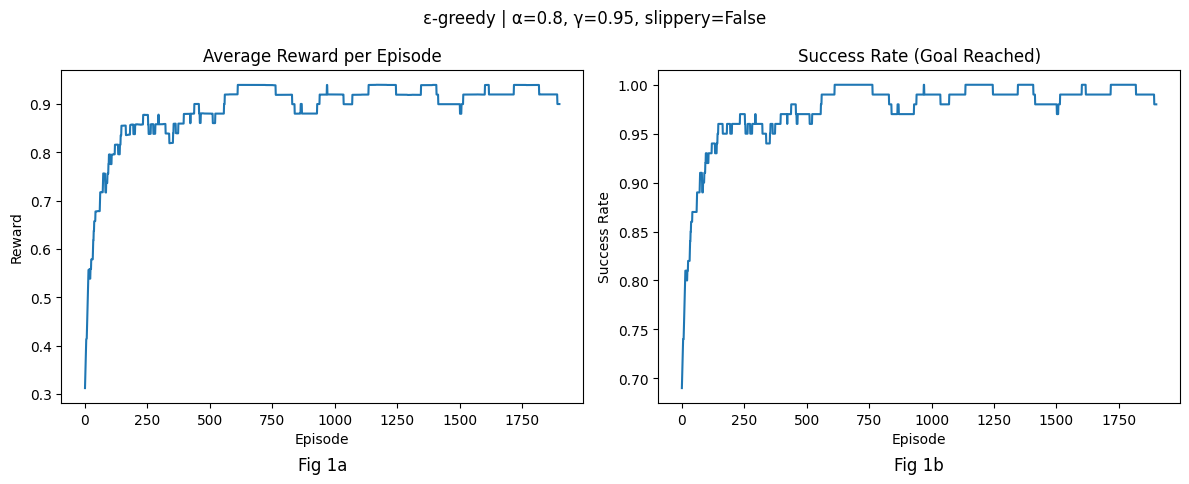

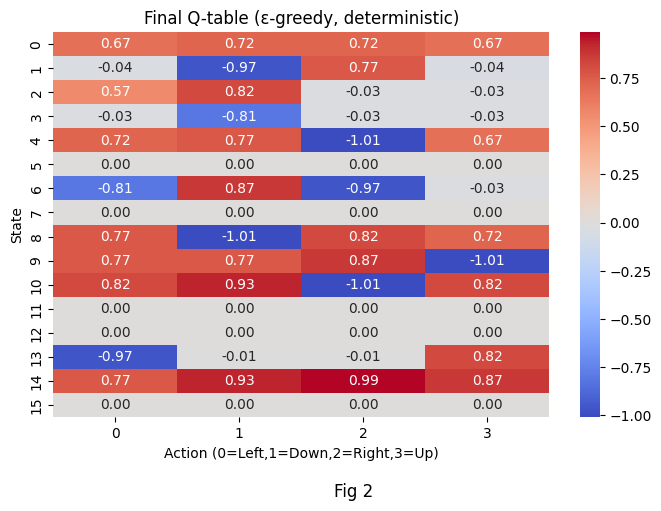

In [67]:
Q, rewards, success = train_q_learning(
    is_slippery=False,
    alpha=0.8,
    gamma=0.95,
    epsilon=0.2,
    episodes=2000,
    policy="epsilon_greedy",
    step_penalty=-0.01,
    hole_penalty=-1.0
)

plot_learning_curves(rewards, success, title="ε-greedy | α=0.8, γ=0.95, slippery=False")

plot_q_heatmap(Q, title="Final Q-table (ε-greedy, deterministic)")


In [68]:
# setting initual parameters
episodes = 2000
alpha = 0.8
gamma = 0.95
is_slippery = False 
step_penalty = -0.01
hole_penalty = -1.0

In [69]:
# epsilon greedy
Q_eg, rewards_eg, success_eg = train_q_learning(
    is_slippery=is_slippery,
    alpha=alpha,
    gamma=gamma,
    epsilon=0.2,
    episodes=episodes,
    policy="epsilon_greedy",
    step_penalty=step_penalty,
    hole_penalty=hole_penalty
)

Episode 500/2000 | Avg reward last 500: 0.737 | ε=0.016
Episode 1000/2000 | Avg reward last 500: 0.908 | ε=0.010
Episode 1500/2000 | Avg reward last 500: 0.928 | ε=0.010
Episode 2000/2000 | Avg reward last 500: 0.916 | ε=0.010


In [70]:
# boltzmann, temperature=1.0
Q_b1, rewards_b1, success_b1 = train_q_learning(
    is_slippery=is_slippery,
    alpha=alpha,
    gamma=gamma,
    episodes=episodes,
    policy="boltzmann",
    temperature=1.0,
    step_penalty=step_penalty,
    hole_penalty=hole_penalty
)

Episode 500/2000 | Avg reward last 500: -0.714 | ε=0.010
Episode 1000/2000 | Avg reward last 500: -0.717 | ε=0.010
Episode 1500/2000 | Avg reward last 500: -0.727 | ε=0.010
Episode 2000/2000 | Avg reward last 500: -0.719 | ε=0.010


In [71]:
# boltzmann, temperature=0.5
Q_b05, rewards_b05, success_b05 = train_q_learning(
    is_slippery=is_slippery,
    alpha=alpha,
    gamma=gamma,
    episodes=episodes,
    policy="boltzmann",
    temperature=0.5,
    step_penalty=step_penalty,
    hole_penalty=hole_penalty
)

Episode 500/2000 | Avg reward last 500: 0.108 | ε=0.010
Episode 1000/2000 | Avg reward last 500: 0.158 | ε=0.010
Episode 1500/2000 | Avg reward last 500: 0.072 | ε=0.010
Episode 2000/2000 | Avg reward last 500: 0.099 | ε=0.010


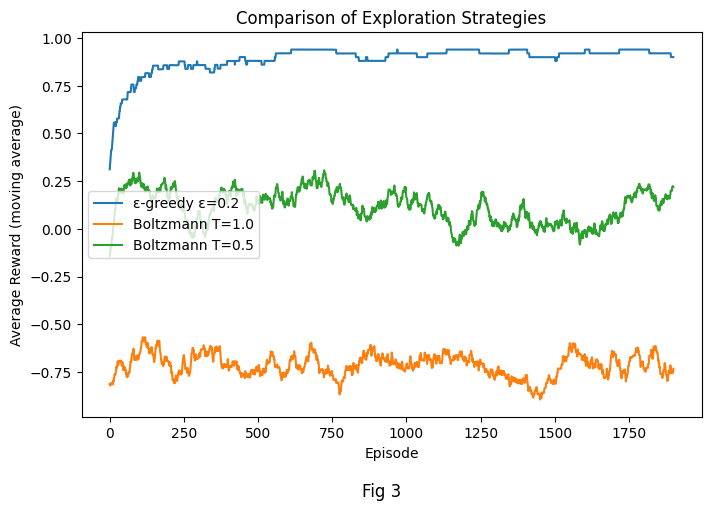

In [72]:
def plot_comparison(rewards_list, labels, window=100, title="Comparison of Exploration Strategies", fig_label=None):
    plt.figure(figsize=(8,5))
    def moving_average(data, w):
        return np.convolve(data, np.ones(w)/w, mode="valid")

    for rewards, label in zip(rewards_list, labels):
        plt.plot(moving_average(rewards, window), label=label)

    plt.xlabel("Episode")
    plt.ylabel("Average Reward (moving average)")
    plt.title(title)
    plt.legend()
    
    if fig_label is not None:
        plt.figtext(0.5, -0.05, fig_label, ha='center', fontsize=12)

    plt.show()

plot_comparison(
    rewards_list=[rewards_eg, rewards_b1, rewards_b05],
    labels=["ε-greedy ε=0.2", "Boltzmann T=1.0", "Boltzmann T=0.5"],
    fig_label="Fig 3"

)


In [73]:
episodes = 2000
alpha = 0.8
gamma = 0.95
step_penalty = -0.01
hole_penalty = -1.0

In [74]:
# deterministic, T=0.1
Q_d01, r_d01, s_d01 = train_q_learning(
    is_slippery=False,
    alpha=alpha,
    gamma=gamma,
    episodes=episodes,
    policy="boltzmann",
    temperature=0.1,
    step_penalty=step_penalty,
    hole_penalty=hole_penalty
)


Episode 500/2000 | Avg reward last 500: 0.895 | ε=0.010
Episode 1000/2000 | Avg reward last 500: 0.925 | ε=0.010
Episode 1500/2000 | Avg reward last 500: 0.914 | ε=0.010
Episode 2000/2000 | Avg reward last 500: 0.904 | ε=0.010


In [75]:
# deterministic, T=0.5
Q_d05, r_d05, s_d05 = train_q_learning(
    is_slippery=False,
    alpha=alpha,
    gamma=gamma,
    episodes=episodes,
    policy="boltzmann",
    temperature=0.5,
    step_penalty=step_penalty,
    hole_penalty=hole_penalty
)

Episode 500/2000 | Avg reward last 500: 0.108 | ε=0.010
Episode 1000/2000 | Avg reward last 500: 0.158 | ε=0.010
Episode 1500/2000 | Avg reward last 500: 0.072 | ε=0.010
Episode 2000/2000 | Avg reward last 500: 0.099 | ε=0.010


In [76]:
# slippery, T=0.1
Q_s01, r_s01, s_s01 = train_q_learning(
    is_slippery=True,
    alpha=alpha,
    gamma=gamma,
    episodes=episodes,
    policy="boltzmann",
    temperature=0.1,
    step_penalty=step_penalty,
    hole_penalty=hole_penalty
)

Episode 500/2000 | Avg reward last 500: -0.488 | ε=0.010
Episode 1000/2000 | Avg reward last 500: -0.321 | ε=0.010
Episode 1500/2000 | Avg reward last 500: -0.450 | ε=0.010
Episode 2000/2000 | Avg reward last 500: -0.351 | ε=0.010


In [77]:
# slippery, T=0.5
Q_s05, r_s05, s_s05 = train_q_learning(
    is_slippery=True,
    alpha=alpha,
    gamma=gamma,
    episodes=episodes,
    policy="boltzmann",
    temperature=0.5,
    step_penalty=step_penalty,
    hole_penalty=hole_penalty
)

Episode 500/2000 | Avg reward last 500: -1.033 | ε=0.010
Episode 1000/2000 | Avg reward last 500: -0.986 | ε=0.010
Episode 1500/2000 | Avg reward last 500: -1.016 | ε=0.010
Episode 2000/2000 | Avg reward last 500: -1.047 | ε=0.010


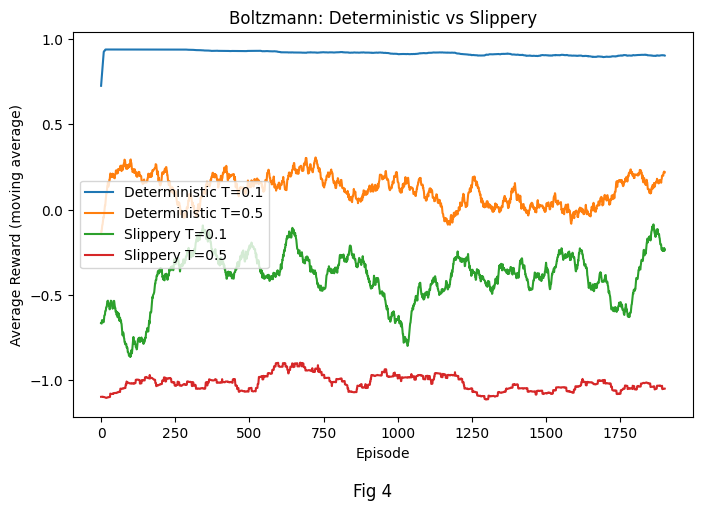

In [78]:
plot_comparison(
    rewards_list=[r_d01, r_d05, r_s01, r_s05],
    labels=[
        "Deterministic T=0.1",
        "Deterministic T=0.5",
        "Slippery T=0.1",
        "Slippery T=0.5"
    ],
    window=100,
    title="Boltzmann: Deterministic vs Slippery",
    fig_label="Fig 4"

)


In [79]:
episodes = 2000
alpha = 0.8
gamma = 0.95
step_penalty = -0.01
hole_penalty = -1.0

# Slippery ε-greedy: explore vs exploit
epsilon_explore = 0.2
epsilon_exploit = 0.05


In [80]:
 # slippery exploration
Q_slip_explore, r_slip_explore, s_slip_explore = train_q_learning(
    is_slippery=True,
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon_explore,
    episodes=episodes,
    policy="epsilon_greedy",
    step_penalty=step_penalty,
    hole_penalty=hole_penalty
)

Episode 500/2000 | Avg reward last 500: -0.737 | ε=0.016
Episode 1000/2000 | Avg reward last 500: -0.575 | ε=0.010
Episode 1500/2000 | Avg reward last 500: -0.672 | ε=0.010
Episode 2000/2000 | Avg reward last 500: -0.800 | ε=0.010


In [81]:
# slippery exploitation
Q_slip_exploit, r_slip_exploit, s_slip_exploit = train_q_learning(
    is_slippery=True,
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon_exploit,
    episodes=episodes,
    policy="epsilon_greedy",
    step_penalty=step_penalty,
    hole_penalty=hole_penalty
)

Episode 500/2000 | Avg reward last 500: -0.954 | ε=0.010
Episode 1000/2000 | Avg reward last 500: -0.883 | ε=0.010
Episode 1500/2000 | Avg reward last 500: -0.945 | ε=0.010
Episode 2000/2000 | Avg reward last 500: -0.959 | ε=0.010


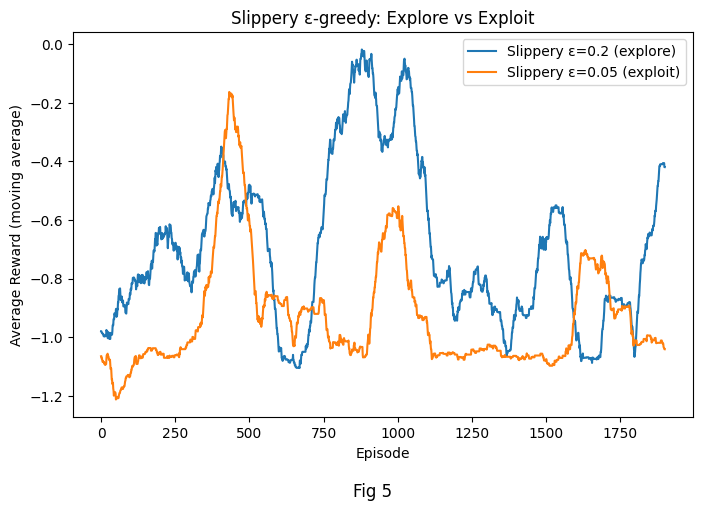

In [82]:
# plot comparison
plot_comparison(
    rewards_list=[r_slip_explore, r_slip_exploit],
    labels=["Slippery ε=0.2 (explore)", "Slippery ε=0.05 (exploit)"],
    window=100,
    title="Slippery ε-greedy: Explore vs Exploit",
    fig_label="Fig 5"
)

In [83]:
def plot_policy_arrows(Q, env_desc, title="Learned Policy", fig_label=None):
    action_symbols = {0: "←", 1: "↓", 2: "→", 3: "↑"}  
    nrow, ncol = env_desc.shape
    policy_grid = np.full((nrow, ncol), '', dtype=object)
    
    for r in range(nrow):
        for c in range(ncol):
            state = r * ncol + c
            if env_desc[r, c] in [b'H', b'G']:  
                policy_grid[r, c] = env_desc[r, c].decode()
            else:
                best_action = np.argmax(Q[state])
                policy_grid[r, c] = action_symbols[best_action]
    
   
    for row in policy_grid:
        print(' '.join(row))
    
    plt.figure(figsize=(6,6))
    sns.heatmap(np.max(Q, axis=1).reshape(nrow, ncol), annot=policy_grid, fmt='', cbar=True, cmap="YlGnBu")
    plt.title(title)

    if fig_label is not None:
        plt.figtext(0.5, -0.05, fig_label, ha='center', fontsize=12)
     
    plt.show()


→ → ↓ ←
↓ H ↓ H
→ ↓ ↓ H
H → → G


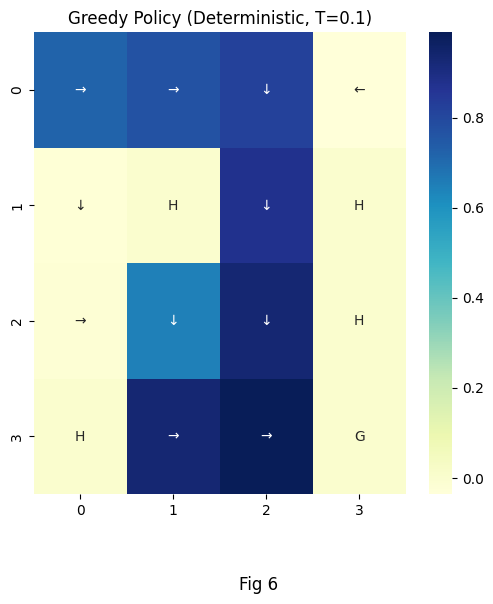

In [84]:
env = gym.make("FrozenLake-v1", is_slippery=False)
env.reset()

plot_policy_arrows(Q_d01, env.unwrapped.desc, title="Greedy Policy (Deterministic, T=0.1)", fig_label="Fig 6")
env.close()


Episode 500/2000 | Avg reward last 500: -0.404 | ε=0.016
Episode 1000/2000 | Avg reward last 500: -0.020 | ε=0.010
Episode 1500/2000 | Avg reward last 500: -0.030 | ε=0.010
Episode 2000/2000 | Avg reward last 500: -0.014 | ε=0.010
Episode 500/2000 | Avg reward last 500: 0.737 | ε=0.016
Episode 1000/2000 | Avg reward last 500: 0.908 | ε=0.010
Episode 1500/2000 | Avg reward last 500: 0.928 | ε=0.010
Episode 2000/2000 | Avg reward last 500: 0.916 | ε=0.010
Episode 500/2000 | Avg reward last 500: 0.484 | ε=0.016
Episode 1000/2000 | Avg reward last 500: 0.668 | ε=0.010
Episode 1500/2000 | Avg reward last 500: 0.686 | ε=0.010
Episode 2000/2000 | Avg reward last 500: 0.675 | ε=0.010


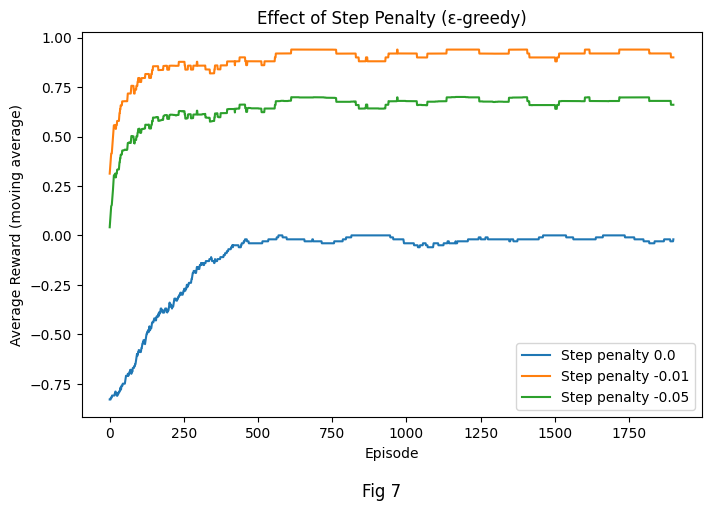

In [94]:
# set up 
episodes = 2000
alpha = 0.8
gamma = 0.95
is_slippery = False  

# step penalty
step_penalties = [0.0, -0.01, -0.05]
Q_list = []
rewards_list = []

for sp in step_penalties:
    Q_tmp, r_tmp, s_tmp = train_q_learning(
        is_slippery=is_slippery,
        alpha=alpha,
        gamma=gamma,
        episodes=episodes,
        policy="epsilon_greedy",
        epsilon=0.2,
        step_penalty=sp,
        hole_penalty=-1.0
    )
    Q_list.append(Q_tmp)
    rewards_list.append(r_tmp)
    
plot_comparison(
    rewards_list=rewards_list,
    labels=[f"Step penalty {sp}" for sp in step_penalties],
    window=100,
    title="Effect of Step Penalty (ε-greedy)",
    fig_label="Fig 7"
    
)


Episode 500/2000 | Avg reward last 500: 0.737 | ε=0.016
Episode 1000/2000 | Avg reward last 500: 0.908 | ε=0.010
Episode 1500/2000 | Avg reward last 500: 0.928 | ε=0.010
Episode 2000/2000 | Avg reward last 500: 0.916 | ε=0.010
Episode 500/2000 | Avg reward last 500: 0.337 | ε=0.016
Episode 1000/2000 | Avg reward last 500: 0.844 | ε=0.010
Episode 1500/2000 | Avg reward last 500: 0.904 | ε=0.010
Episode 2000/2000 | Avg reward last 500: 0.868 | ε=0.010


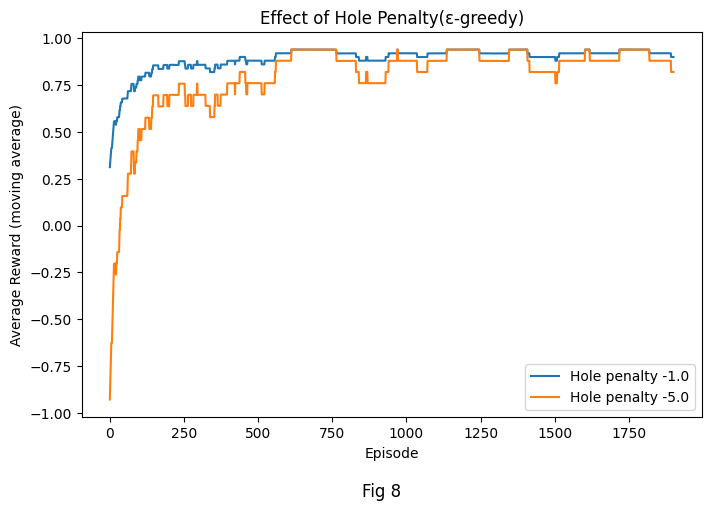

In [93]:
# hole penalty
hole_penalties = [-1.0, -5.0]
Q_h_list = []
rewards_h_list = []

for hp in hole_penalties:
    Q_tmp, r_tmp, s_tmp = train_q_learning(
        is_slippery=is_slippery,
        alpha=alpha,
        gamma=gamma,
        episodes=episodes,
        policy="epsilon_greedy",
        epsilon=0.2,
        step_penalty=-0.01,
        hole_penalty=hp
    )
    Q_h_list.append(Q_tmp)
    rewards_h_list.append(r_tmp)

plot_comparison(
    rewards_list=rewards_h_list,
    labels=[f"Hole penalty {hp}" for hp in hole_penalties],
    window=100,
    title="Effect of Hole Penalty(ε-greedy)",
    fig_label="Fig 8"
)